#**Машинное обучение ИБ-2024**

#**Домашнее задание 2.**
#Классификация, KNN, LogReg, SVC.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## **Теоретическая Часть**

Мы рассматриваем задачу бинарной классификации. Для прогнозирования мы хотели бы использовать модель логистической регрессии. Для регуляризации мы добавляем комбинацию штрафов в размере $l_2$ и $l_1$ (Elastic Net).

Каждый объект в обучающем наборе данных индексируется с помощью $i$ и описывается парой: объекты $x_i\in\mathbb{R}^{K}$ и двоичные метки $y_i$. Модель параметризуется со смещением $w_0\in\mathbb{R}$ и весами $w\in\mathbb{R}^K$.

Задача оптимизации в отношении $w_0, w$ заключается в следующем (Elastic Net Loss):

$$L(w, w_0) = \frac{1}{N} \sum_{i=1}^N \ln(1+\exp(-y_i(w^\top x_i+w_0))) + \gamma \|w\|_1 + \beta \|w\|_2^2$$.



Градиенты функции потерь логистической регрессии представлены ниже:

$$dL(w, w_0)/ dw = -\frac{1}{N}  \frac{X*y^\top}{1 + \exp(y (Xw+w_0)))} + \gamma * sign(w) + 2 * beta * w$$

$$dL(w, w_0)/ dw_0 = -\frac{1}{N}  \frac{y}{1 + \exp(y*(Xw+w_0)))}$$

#### 1. [0.5 Балл] Реализуйте функцию, выдающий значение функции потерь логичтической регрессии:

In [83]:
def loss(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> float:
  N = len(y)
  w = np.array(w)

  prediction = 1 / (1 + np.exp(-(X @ w + w0)))

  log_loss = -np.mean(y * np.log(prediction) + (1 - y) * np.log(1 - prediction))

  l1 = gamma * np.sum(np.abs(w))
  l2 = beta * np.sum(w ** 2)

  total = log_loss + l1 + l2

  return total

#### 2. [0.5 Балл] Реализуйте функцию, которая будет возвращать градиенты весов вашей модели Логистической регрессии:

In [84]:
def get_grad(X, y, w: List[float], w0: float, gamma=1., beta=1.) -> Tuple[List[float], float]:
    w = np.array(w)

    sigmoid = 1 / (1 + np.exp(y * (X @ w + w0)))
    grad_w = (-1 / X.shape[0]) * (X.T @ (y * sigmoid)) + gamma * np.sign(w) + 2 * beta * w
    grad_w0 = (-1 / X.shape[0]) * np.sum(y * sigmoid)
    return grad_w.tolist(), grad_w0

In [85]:
# код для проверки

np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
y = np.random.binomial(1, 0.42, size=10)
w, w0 = np.random.normal(size=5), np.random.normal()

grad_w, grad_w0 = get_grad(X, y, w, w0)
assert(np.allclose(grad_w,
                   [-2.73262076, -1.87176281, 1.30051144, 2.53598941, -2.71198109],
                   rtol=1e-2) & \
       np.allclose(grad_w0,
                   -0.2078231418067844,
                   rtol=1e-2)
)

####  3. [1 Балл]  Реализуйте класс для модели логистической регрессии, используя выше написанные функции:

Модель должна обучаться методом SGD.

In [86]:
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.metrics import roc_curve

In [87]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-2, tolerance=1e-8, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.lr = lr
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.random_state = random_state
        self.w = None
        self.w0 = None
        self.total_loss = []

    def fit(self, X: np.ndarray, y: np.ndarray):
        np.random.seed(self.random_state)
        self.w = np.zeros(X.shape[1])
        self.w0 = 0

        y = np.where(y > 0, 1, -1)

        for i in range(self.max_iter):
          random_idx = np.random.randint(0, X.shape[0])
          x_i = X[random_idx, :].reshape(1,-1)
          y_i = y[random_idx]

          grad_w, grad_w0 = get_grad(x_i, y_i, self.w, self.w0, self.gamma, self.beta)

          self.w -= self.lr * np.array(grad_w)
          self.w0 -= self.lr * grad_w0

          cur_loss = loss(X, y, self.w, self.w0, self.gamma, self.beta)
          self.total_loss.append(cur_loss)

    def predict(self, X: np.ndarray) -> np.ndarray:
        probabilities = self.predict_proba(X)
        return np.where(probabilities >= 0.5, 1, -1)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        return 1 / (1 + np.exp(-(X @ self.w + self.w0)))

In [88]:
# этот код менять не надо!
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=1800, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

####  4. [0.5 Балл]  Реализуйте функцию, которая отрисовывает объекты вашего датасета, их метки и разделяющую гиперплоскость, полученную от Логистической регрессии (пример того, что должно получиться ниже):

In [89]:
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01),
                         np.arange(y_min, y_max, 0.01))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(xx, yy, Z, alpha=0.3)

    scatter = plt.scatter(X[:, 0], X[:, 1], c=y, edgecolors='k', marker='o', s=50)

    plt.legend(*scatter.legend_elements(), title='Classes')

    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.title('Decision Boundary and Data Points')
    plt.show()

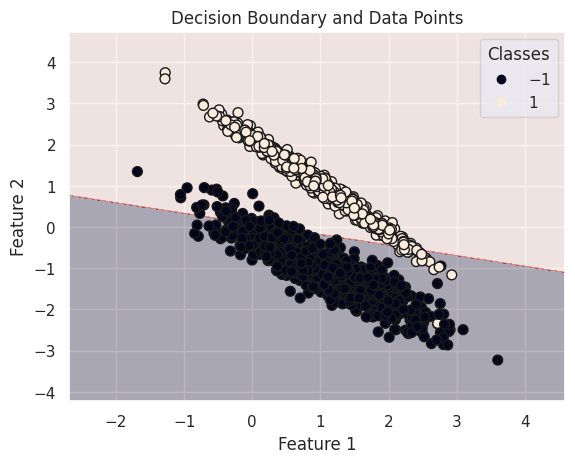

In [90]:
model = Logit(0,0)
y[y == 0] = -1
model.fit(X, y)
plot_decision_boundary(model, X, y)

#### 5. [0.5 Балл] Для предыдущей задачи отобразите на графике, как изменяется значение функция потерь от номера итерации.

In [91]:
def plot_loss_history(model):
    plt.plot(model.total_loss)
    plt.xlabel('Iteration')
    plt.ylabel('Loss')
    plt.title('Loss History of Logistic Regression')
    plt.show()

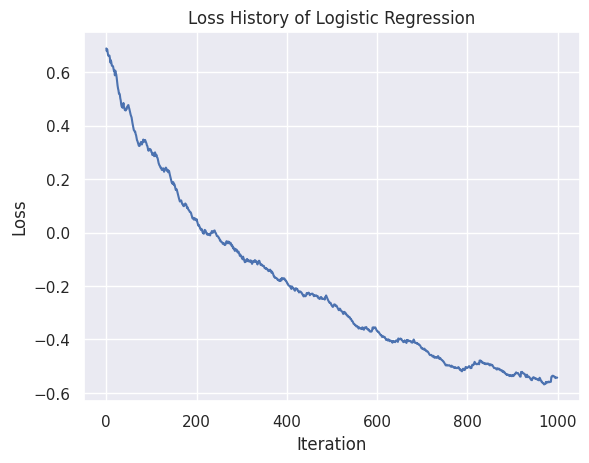

In [92]:
plot_loss_history(model)

#### 6. [2 Балл] Для данных, на которых тестировали модель Логистической регрессии, заиспользуйте модель SVC из библиотеки sklearn. Попробуйте различные ядра (kernel) и различные коэфициенты C. Посмотрите на метрики, которые мы обсуждали на занятии (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [93]:
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
kernels = ['linear', 'poly', 'rbf', 'sigmoid'] #можно еще precomputed, но там на вход нужна особая матрица
C_values = [0.1, 0.5, 1, 2, 5, 10, 100]
for kernel in kernels:
  for C in C_values:
    model = SVC(kernel=kernel, C=C)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    print(f"Kernel: {kernel}, C: {C}")
    print(f"accuracy_score: {accuracy:.3f}")
    print(f"precision_score: {precision:.3f}")
    print(f"recall_score: {recall:.3f}")
    print(f"roc_auc_score: {roc_auc:.3f}")
    print(f"f1_score: {f1:.3f}")
    print("\n######\n")

Kernel: linear, C: 0.1
accuracy_score: 0.994
precision_score: 0.992
recall_score: 0.996
roc_auc_score: 0.994
f1_score: 0.994

######

Kernel: linear, C: 0.5
accuracy_score: 0.994
precision_score: 0.992
recall_score: 0.996
roc_auc_score: 0.994
f1_score: 0.994

######

Kernel: linear, C: 1
accuracy_score: 0.994
precision_score: 0.992
recall_score: 0.996
roc_auc_score: 0.994
f1_score: 0.994

######

Kernel: linear, C: 2
accuracy_score: 0.994
precision_score: 0.992
recall_score: 0.996
roc_auc_score: 0.994
f1_score: 0.994

######

Kernel: linear, C: 5
accuracy_score: 0.994
precision_score: 0.992
recall_score: 0.996
roc_auc_score: 0.994
f1_score: 0.994

######

Kernel: linear, C: 10
accuracy_score: 0.994
precision_score: 0.992
recall_score: 0.996
roc_auc_score: 0.994
f1_score: 0.994

######

Kernel: linear, C: 100
accuracy_score: 0.994
precision_score: 0.992
recall_score: 0.996
roc_auc_score: 0.994
f1_score: 0.994

######

Kernel: poly, C: 0.1
accuracy_score: 0.994
precision_score: 0.992
rec

#### 7. [2 Балл] Реализуйте класс KNNClassifier, который должен реализовывать классификацию путем нахождения k ближайших соседей. В методе predict_proba Вам необходимо выдавать вектор вероятностей для каждого объекта, который означает, что объект является экземпляром i-го класса с p_i вероятностью. Протестируйте Ваш класс на данных, сгенерированных выше, посмотрите на метрики (Acc, Precision, Recall, AUC-ROC, F1-Score).

In [94]:
from sklearn.metrics import pairwise_distances
class KNNClassifier:
    def __init__(self, n_neighbors=5, metric='euclidean'):
        self.n_neighbors = n_neighbors
        self.metric = metric

    def fit(self, X, y):
        self.X_train = X
        self.y_train = y
        self.classes, self.y_train_indices = np.unique(y, return_inverse=True)

    def predict(self, X):
        distances = pairwise_distances(X, self.X_train, metric=self.metric)
        neighbors_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        predictions = np.array([np.bincount(self.y_train_indices[neighbors_indices[i]]).argmax() for i in range(X.shape[0])])
        return self.classes[predictions]

    def predict_proba(self, X):
        distances = pairwise_distances(X, self.X_train, metric=self.metric)
        neighbors_indices = np.argsort(distances, axis=1)[:, :self.n_neighbors]

        proba = np.zeros((X.shape[0], len(np.unique(self.y_train))))

        for i, indices in enumerate(neighbors_indices):
            class_counts = np.bincount(self.y_train[indices], minlength=len(np.unique(self.y_train)))
            proba[i] = class_counts / np.sum(class_counts)

        return proba


In [95]:
knn = KNNClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f"accuracy_score: {accuracy:.3f}")
print(f"precision_score: {precision:.3f}")
print(f"recall_score: {recall:.3f}")
print(f"roc_auc_score: {roc_auc:.3f}")
print(f"f1_score: {f1:.3f}")



accuracy_score: 0.994
precision_score: 0.992
recall_score: 0.996
roc_auc_score: 0.994
f1_score: 0.994


## **Практическая часть**

В этом задании мы будем работать с Датасетом Fashion Mnist. Это датасет, который представляет изображения одного канала с различными типами одежды. Вам необходимо провести полный пайплайн обучения моделей (KNN и Logreg), которые вы можете импортировать из библиотеки sklearn.

#### 8. [0 Балл] Импортируйте датафрейм из csv файла. Поделите выборку следующим образом - :50000 (Train) и 50000: (Test).

In [96]:
df = pd.read_csv('/content/drive/MyDrive/train.csv')
df.head()

,Id,Category,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
0,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,9,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,6,0,0,0,0,0,0,0,5,...,0,0,0,30,43,0,0,0,0,0
3,3,0,0,0,0,1,2,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,4,3,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [97]:
y = df["Category"]
X = df.drop("Category", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=50000, random_state=42)
X_train.head()

,Id,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,Pixel008,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
11210,11210,0,0,0,0,0,0,0,0,0,...,135,0,0,0,0,0,0,0,0,0
17024,17024,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
43389,43389,0,0,0,0,0,5,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30050,30050,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
34665,34665,0,0,0,0,0,0,0,59,155,...,0,0,1,0,0,88,107,20,0,0


In [98]:
X_test.head()

,Id,Pixel000,Pixel001,Pixel002,Pixel003,Pixel004,Pixel005,Pixel006,Pixel007,Pixel008,...,Pixel774,Pixel775,Pixel776,Pixel777,Pixel778,Pixel779,Pixel780,Pixel781,Pixel782,Pixel783
12628,12628,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
37730,37730,0,0,0,0,0,0,0,0,0,...,187,190,196,201,209,221,218,211,102,0
39991,39991,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8525,8525,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
8279,8279,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [99]:
y_train.head()

,Category
11210,1
17024,8
43389,0
30050,5
34665,6


In [100]:
y_test.head()

,Category
12628,7
37730,8
39991,8
8525,5
8279,9


#### 9. [0.5 Балл] Визуализируйте некоторые из объектов датасета. В колонках отображены яркости пикселей, которые представляют из себя изображения Fashion Mnist. С помощью matplotlib визуализируйте по одному представителю каждого класса.

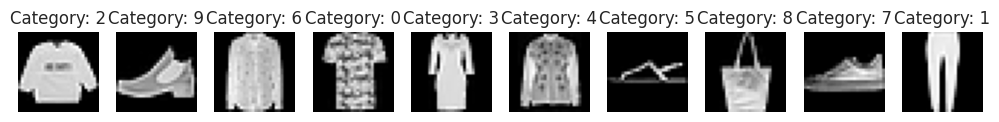

In [101]:
unique_categories = df['Category'].unique()

plt.figure(figsize=(10, 10))

for i, category in enumerate(unique_categories):
    sample = df[df['Category'] == category].iloc[0]

    pixels = sample[2:].values.reshape(28, 28)

    plt.subplot(1, len(unique_categories), i + 1)
    plt.imshow(pixels, cmap='gray')
    plt.title(f'Category: {category}')
    plt.axis('off') # Отключаем оси

plt.tight_layout()
plt.show()

#### 10. [0.5 Балл] Отнормируйте признаки в датасете, попробуйте два варианта StandartScaller и MinMaxScaller.

In [102]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

standard_scaler = StandardScaler()
X_train_StandardScaler = standard_scaler.fit_transform(X_train)
X_test_StandardScaler = standard_scaler.transform(X_test)
print(X_train_StandardScaler)

minmax_scaler = MinMaxScaler()
X_train_MinMaxScaler = minmax_scaler.fit_transform(X_train)
X_test_MinMaxScaler = minmax_scaler.transform(X_test)

print(X_train_MinMaxScaler)

[[-1.08347323 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [-0.74771055 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [ 0.77488714 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 ...
 [-1.68119316 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [-0.81868618 -0.00941399 -0.02213614 ... -0.15872071 -0.09175096
  -0.03167199]
 [ 1.52755225 -0.00941399 -0.02213614 ... -0.10107578 -0.09175096
  -0.03167199]]
[[0.18683956 0.         0.         ... 0.         0.         0.        ]
 [0.28374279 0.         0.         ... 0.         0.         0.        ]
 [0.72317411 0.         0.         ... 0.         0.         0.        ]
 ...
 [0.01433381 0.         0.         ... 0.         0.         0.        ]
 [0.26325878 0.         0.         ... 0.         0.         0.        ]
 [0.94039801 0.         0.         ... 0.00392157 0.         0.        ]]


**На этом все :)**

#### 10. [2 Балл] Проведите эксперименты: для моделей KNeighborsClassifier и LogisticRegression подберите гиперпараметры с помощью GridSerchCV (минимум 5 фолдов). Получите качество моделей на тестовой выборке. Основная метрика в данном задании будет accuracy. Сравните эти две модели. Какая модель показывает лучшее качество, предположите почему и напишите ответ.

**NB!**: в задании нужно подбирать несколько гиперпараметров по сетке. Какие гиперпараметры подбирать - решаете Вы сами. Обязательно обоснуйте, почему и какие параметры Вы подбираете! Например, подбор только гиперпараметра C в LogisticRegression не будет засчитываться как решение данного задания! Попытайтесь серьезно отнестись к нему, будто вы за это получите зарплату 300к.

## **Бонусы**

#### Задача 1. [1 Балл] У Вас есть датасет с 10**4 объектами. У всех объектов два признака и все они одинаковые у всех объектов. Однако, 5000 - отрицательного класса и 5000 - положительного класса. Вы запускате Логистическую регрессию для классификации на данном датасете. Что Вы получите в итоге обучения данной модели на SGD? Ответ обоснуйте.

#### Задача 2. [1 Балл] При классификации Fashion Mnist модель Логистической регрессии на обучении многоклассовой классификации методом One-VS-All у Вас получилось k классификаторов. Изобразите веса ваших полученных моделей как изображения в matplotlib. Возможно, модель выучила какие-то графические паттерны в данных? Ответ обоснуйте.

#### Задача 3. [1 Балл] В задаче классификации Fashion Mnist Вы попытались выбить какой-то accuracy. Для получения бонусного балла Вам нужно на той же самой выборке получить значение метрики accuracy > 0.87 на тесте (Тестовую выборку менять нельзя, но обучающую можно). Какими моделями и методами Вы это будете делать - на Ваше усмотрение, но **нельзя использовать никакие нейронные сети**. Необходимо получить модель машинного обучения, выполняющую эту задачу.